In [35]:
import pandas as pd
from functions import *

### 1-Préparation des données

#### &nbsp;&nbsp;a) Merger les datas en un seul dataframe

In [36]:
#charger chaque fichier, retirer les lignes vides et regarder les entetes
enron = pd.read_csv('source_data/enron.csv')
enron.dropna()
enron.head()

Message ID                       Subject  \
0           0  christmas tree farm pictures   
1           1      vastar resources , inc .   
2           2  calpine daily gas nomination   
3           3                    re : issue   
4           4     meter 7268 nov allocation   

                                             Message Spam/Ham        Date  
0                                                NaN      ham  1999-12-10  
1  gary , production from the high island larger ...      ham  1999-12-13  
2             - calpine daily gas nomination 1 . doc      ham  1999-12-14  
3  fyi - see note below - already done .\nstella\...      ham  1999-12-14  
4  fyi .\n- - - - - - - - - - - - - - - - - - - -...      ham  1999-12-14

In [37]:
ling = pd.read_csv('source_data/ling.csv')
ling= ling.dropna()
ling.head()

subject  \
0            job posting - apple-iss research center   
2  query : letter frequencies for text identifica...   
3                                               risk   
4                           request book information   
5  call for abstracts : optimality in syntactic t...   

                                             message  label  
0  content - length : 3386 apple-iss research cen...      0  
2  i am posting this inquiry for sergei atamas ( ...      0  
3  a colleague and i are researching the differin...      0  
4  earlier this morning i was on the phone with a...      0  
5  content - length : 4437 call for papers is the...      0

In [38]:
spamassassin = pd.read_csv('source_data/spamassassin.csv')
spamassassin = spamassassin[spamassassin['Body'] != 'empty']
spamassassin.head()

Unnamed: 0                                               Body  Label
0           0  \nSave up to 70% on Life Insurance.\nWhy Spend...      1
1           1  1) Fight The Risk of Cancer!\nhttp://www.adcli...      1
2           2  1) Fight The Risk of Cancer!\nhttp://www.adcli...      1
3           3  ##############################################...      1
4           4  I thought you might like these:\n1) Slim Down ...      1

In [39]:
spdivers = pd.read_csv('source_data/spam.csv')
spdivers.head()

Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...

In [40]:
#creer le dataframe 
df=pd.DataFrame()

#merger sujet et message
df["message"]=enron["Subject"]+" "+enron["Message"]
df['spam']=enron["Spam/Ham"]

#preparer les données et concatener dans le dataframe
ling_renamed=pd.DataFrame()
ling_renamed['message']=ling['subject']+ " " + ling['message']
ling_renamed['spam']=ling['label']
df = pd.concat([df, ling_renamed], ignore_index=True)

#idem pour spam assasin
spamassassin_renamed=pd.DataFrame()
spamassassin_renamed = spamassassin.rename(columns={'Body': 'message', 'Label': 'spam'})
spamassassin_renamed = spamassassin_renamed.drop(columns=["Unnamed: 0"])
df = pd.concat([df, spamassassin_renamed], ignore_index=True)

#et spdivers
spdivers_renamed = spdivers.rename(columns={'Message': 'message', 'Category': 'spam'})
df = pd.concat([df, spdivers_renamed], ignore_index=True)

df.describe()

#liberer explicitement la mémoire
del spdivers_renamed,ling_renamed,spamassassin_renamed,enron,ling,spamassassin,spdivers

In [41]:
#supprimer les messages en doublon
df = df.drop_duplicates(subset=['message'])
df.describe()

message   spam
count                        43298  43299
unique                       43298      4
top     Rofl. Its true to its name    ham
freq                             1  20378

In [42]:
#supprimer les NAN
df = df.dropna(subset=['message']).reset_index(drop=True)
#supprimer les messages de moins de 50 caracteres
df = remove_short_messages(df,'message')

In [43]:
#transformer les labels en 0:ham, 1:spam

df['spam']=df['spam'].replace({'spam':1,'ham':0,'0.0':0,'1.1':1})
df = df.drop(36195)
df = df.reset_index(drop=True)
print(df.tail())
print(df.describe())
spam_count = df['spam'].value_counts()
print("\nNombre de spam et de ham :")
print(spam_count)

                                                 message  spam
40934  Why don't you wait 'til at least wednesday to ...     0
40935  REMINDER FROM O2: To get 2.50 pounds free call...     1
40936  This is the 2nd time we have tried 2 contact u...     1
40937  Pity, * was in mood for that. So...any other s...     0
40938  The guy did some bitching but I acted like i'd...     0
               spam
count  40939.000000
mean       0.402892
std        0.490485
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000

Nombre de spam et de ham :
spam
0    24445
1    16494
Name: count, dtype: int64


C:\Users\webma\AppData\Local\Temp\ipykernel_14828\335518638.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['spam']=df['spam'].replace({'spam':1,'ham':0,'0.0':0,'1.1':1})


#### &nbsp;&nbsp;b) Ajouter des features

In [44]:
df=add_features(df)
df.head()

message  spam  message_length  \
0  vastar resources , inc . gary , production fro...     0            4307   
1  calpine daily gas nomination - calpine daily g...     0              67   
2  re : issue fyi - see note below - already done...     0            1182   
3  meter 7268 nov allocation fyi .\n- - - - - - -...     0            1150   
4  mcmullen gas for 11 / 99 jackie ,\nsince the i...     0             559   

   word_count  special_char_count  keyword_count  keyword_ratio  url_count  \
0        1577                  12              0          0.000          0   
1          12                   0              0          0.000          0   
2         347                   8              0          0.000          0   
3         322                   6              0          0.000          0   
4         125                   0              2          0.016          0   

   promo_word_count  promo_word_ratio  letter_digit_ratio  pronoun_count  \
0                 1          0.000634            4.034921             17   
1                 0          0.000000           53.000000              0   
2                 1          0.002882            8.794118             12   
3                 0          0.000000           10.474576             10   
4                 1          0.008000           16.956522              6   

   uppercase_ratio  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0

#### &nbsp;&nbsp;c) Nettoyer et lemmatiser les textes

In [45]:
df=nettoyer_texte(df,'message')
df= df.dropna()
df.head()

Nettoyage des messages: 100%|██████████| 40939/40939 [18:41<00:00, 36.52it/s]  


message  spam  message_length  \
0  gary production high island large block commen...     0            4307   
1      calpine gas nomination calpine gas nomination     0              67   
2  issue fyi note .stella- forward ect    -from s...     0            1182   
3  allocation fyi forward lauri allen hou ect    ...     0            1150   
4  mcmullen gas jackie inlet river plant shut day...     0             559   

   word_count  special_char_count  keyword_count  keyword_ratio  url_count  \
0        1577                  12              0          0.000          0   
1          12                   0              0          0.000          0   
2         347                   8              0          0.000          0   
3         322                   6              0          0.000          0   
4         125                   0              2          0.016          0   

   promo_word_count  promo_word_ratio  letter_digit_ratio  pronoun_count  \
0                 1          0.000634            4.034921             17   
1                 0          0.000000           53.000000              0   
2                 1          0.002882            8.794118             12   
3                 0          0.000000           10.474576             10   
4                 1          0.008000           16.956522              6   

   uppercase_ratio  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0

### 2-Analyse des données

In [46]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer


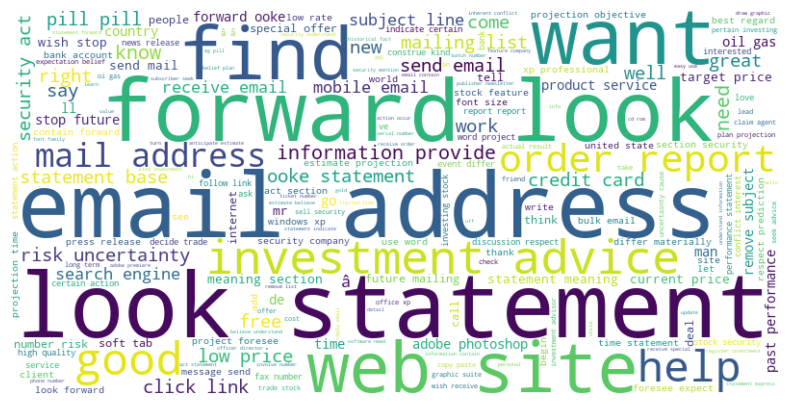

In [47]:
#petit wordcloud du spam
dfwcloud=df[df['spam']==1]
text = " ".join(message for message in dfwcloud['message'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Supprimer les axes
plt.show()

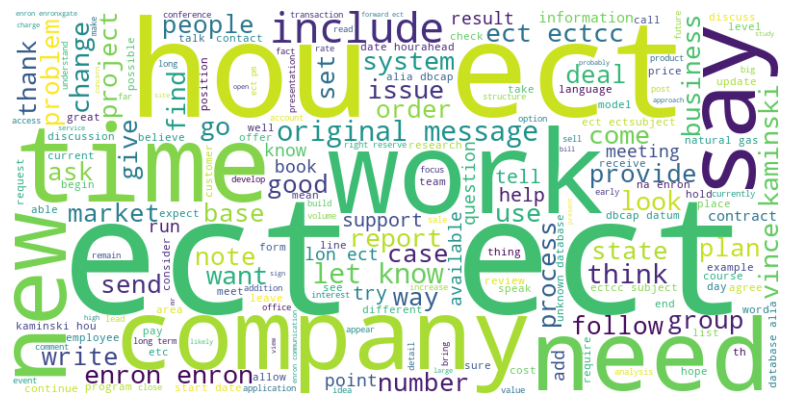

In [48]:
#petit wordcloud du ham
dfwcloud=df[df['spam']==0]
text = " ".join(message for message in dfwcloud['message'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Supprimer les axes
plt.show()

del dfwcloud
del wordcloud

#### &nbsp;&nbsp;a) Selection des features utiles

In [49]:
# Sélectionner les colonnes numériques sauf spam
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
numerical_cols = [col for col in numerical_cols if col != 'spam']

In [50]:
# suppression des outliers
# quelques messages parasites sont dans le dataframe
def detect_high_outliers(df, column, nbecarttype=5):
    #Détecte les valeurs qui se trouvent à nbecarttype écarts-types au-dessus de la moyenne.

    mean = df[column].mean()
    std_dev = df[column].std()
    upper_bound = mean + nbecarttype * std_dev
    
    # Identifier les lignes avec des valeurs supérieures à `upper_bound`
    high_outliers = df[df[column] > upper_bound]
    return high_outliers, upper_bound

def detect_outliers(df, columns,nbecarttype=5):
    outlier_dict = {}
    for col in columns:
        outliers, upper = detect_high_outliers(df, col,nbecarttype)
        outlier_dict[col] = {
            'outliers': outliers,
            'upper_bound': upper
        }
    return outlier_dict

outlier_results = detect_outliers(df, numerical_cols,5)
# Résumé des résultats
for col, res in outlier_results.items():
    print(f"Colonne: {col}")
    print(f"  - Nombre d'outliers : {len(res['outliers'])}")
    print(f"  - Borne sup :  {res['upper_bound']}")
    
del outlier_results

Colonne: message_length
  - Nombre d'outliers : 125
  - Borne sup :  22473.49692102441
Colonne: word_count
  - Nombre d'outliers : 132
  - Borne sup :  4238.764162466209
Colonne: special_char_count
  - Nombre d'outliers : 236
  - Borne sup :  155.54386809933564
Colonne: keyword_count
  - Nombre d'outliers : 171
  - Borne sup :  11.41001012379048
Colonne: keyword_ratio
  - Nombre d'outliers : 257
  - Borne sup :  0.09264801591967176
Colonne: url_count
  - Nombre d'outliers : 3
  - Borne sup :  78.1676994674131
Colonne: promo_word_count
  - Nombre d'outliers : 180
  - Borne sup :  9.464735004780191
Colonne: promo_word_ratio
  - Nombre d'outliers : 234
  - Borne sup :  0.09348008139220416
Colonne: letter_digit_ratio
  - Nombre d'outliers : 180
  - Borne sup :  823.8941791838763
Colonne: pronoun_count
  - Nombre d'outliers : 0
  - Borne sup :  47.552996462387284
Colonne: uppercase_ratio
  - Nombre d'outliers : 188
  - Borne sup :  0.22819518897649663


In [51]:
#supprimer les outliers a threshold ecart types de la moyenne
def remove_high_outliers(df, numerical_columns, threshold=5):
    for column in numerical_columns:
        mean = df[column].mean()
        std_dev = df[column].std()
        upper_bound = mean + threshold * std_dev
        
        # Supprimer les outliers qui sont au-dessus de la limite supérieure
        df = df[df[column] <= upper_bound]
    
    return df

# Sélectionner les colonnes numériques (externe à la fonction)
numerical_columns = df.select_dtypes(include=['number']).columns

df=remove_high_outliers(df,numerical_cols,5)#On supprime a 5 ecart type


In [52]:
df.describe()

spam  message_length    word_count  special_char_count  \
count  39059.000000    39059.000000  39059.000000        39059.000000   
mean       0.396887     1278.129701    254.980337            3.841112   
std        0.489258     1586.587055    311.763880            9.190245   
min        0.000000       50.000000      1.000000            0.000000   
25%        0.000000      329.000000     64.000000            0.000000   
50%        0.000000      726.000000    144.000000            1.000000   
75%        1.000000     1553.000000    314.000000            4.000000   
max        1.000000    17248.000000   2296.000000          117.000000   

       keyword_count  keyword_ratio     url_count  promo_word_count  \
count   39059.000000   39059.000000  39059.000000      39059.000000   
mean        1.117745       0.006494      0.178883          1.141376   
std         1.685889       0.011834      0.656294          1.373988   
min         0.000000       0.000000      0.000000          0.000000   
25%         0.000000       0.000000      0.000000          0.000000   
50%         0.000000       0.000000      0.000000          1.000000   
75%         2.000000       0.008197      0.000000          2.000000   
max        10.000000       0.090909      6.000000          8.000000   

       promo_word_ratio  letter_digit_ratio  pronoun_count  uppercase_ratio  
count      39059.000000        39059.000000   39059.000000     39059.000000  
mean           0.007436           54.591543      12.713766         0.008804  
std            0.011887           92.936382       6.566069         0.023321  
min            0.000000            0.000000       0.000000         0.000000  
25%            0.000000            6.600000       8.000000         0.000000  
50%            0.002907           22.500000      13.000000         0.000000  
75%            0.009615           59.622507      17.000000         0.000000  
max            0.078431          826.000000      39.000000         0.222222

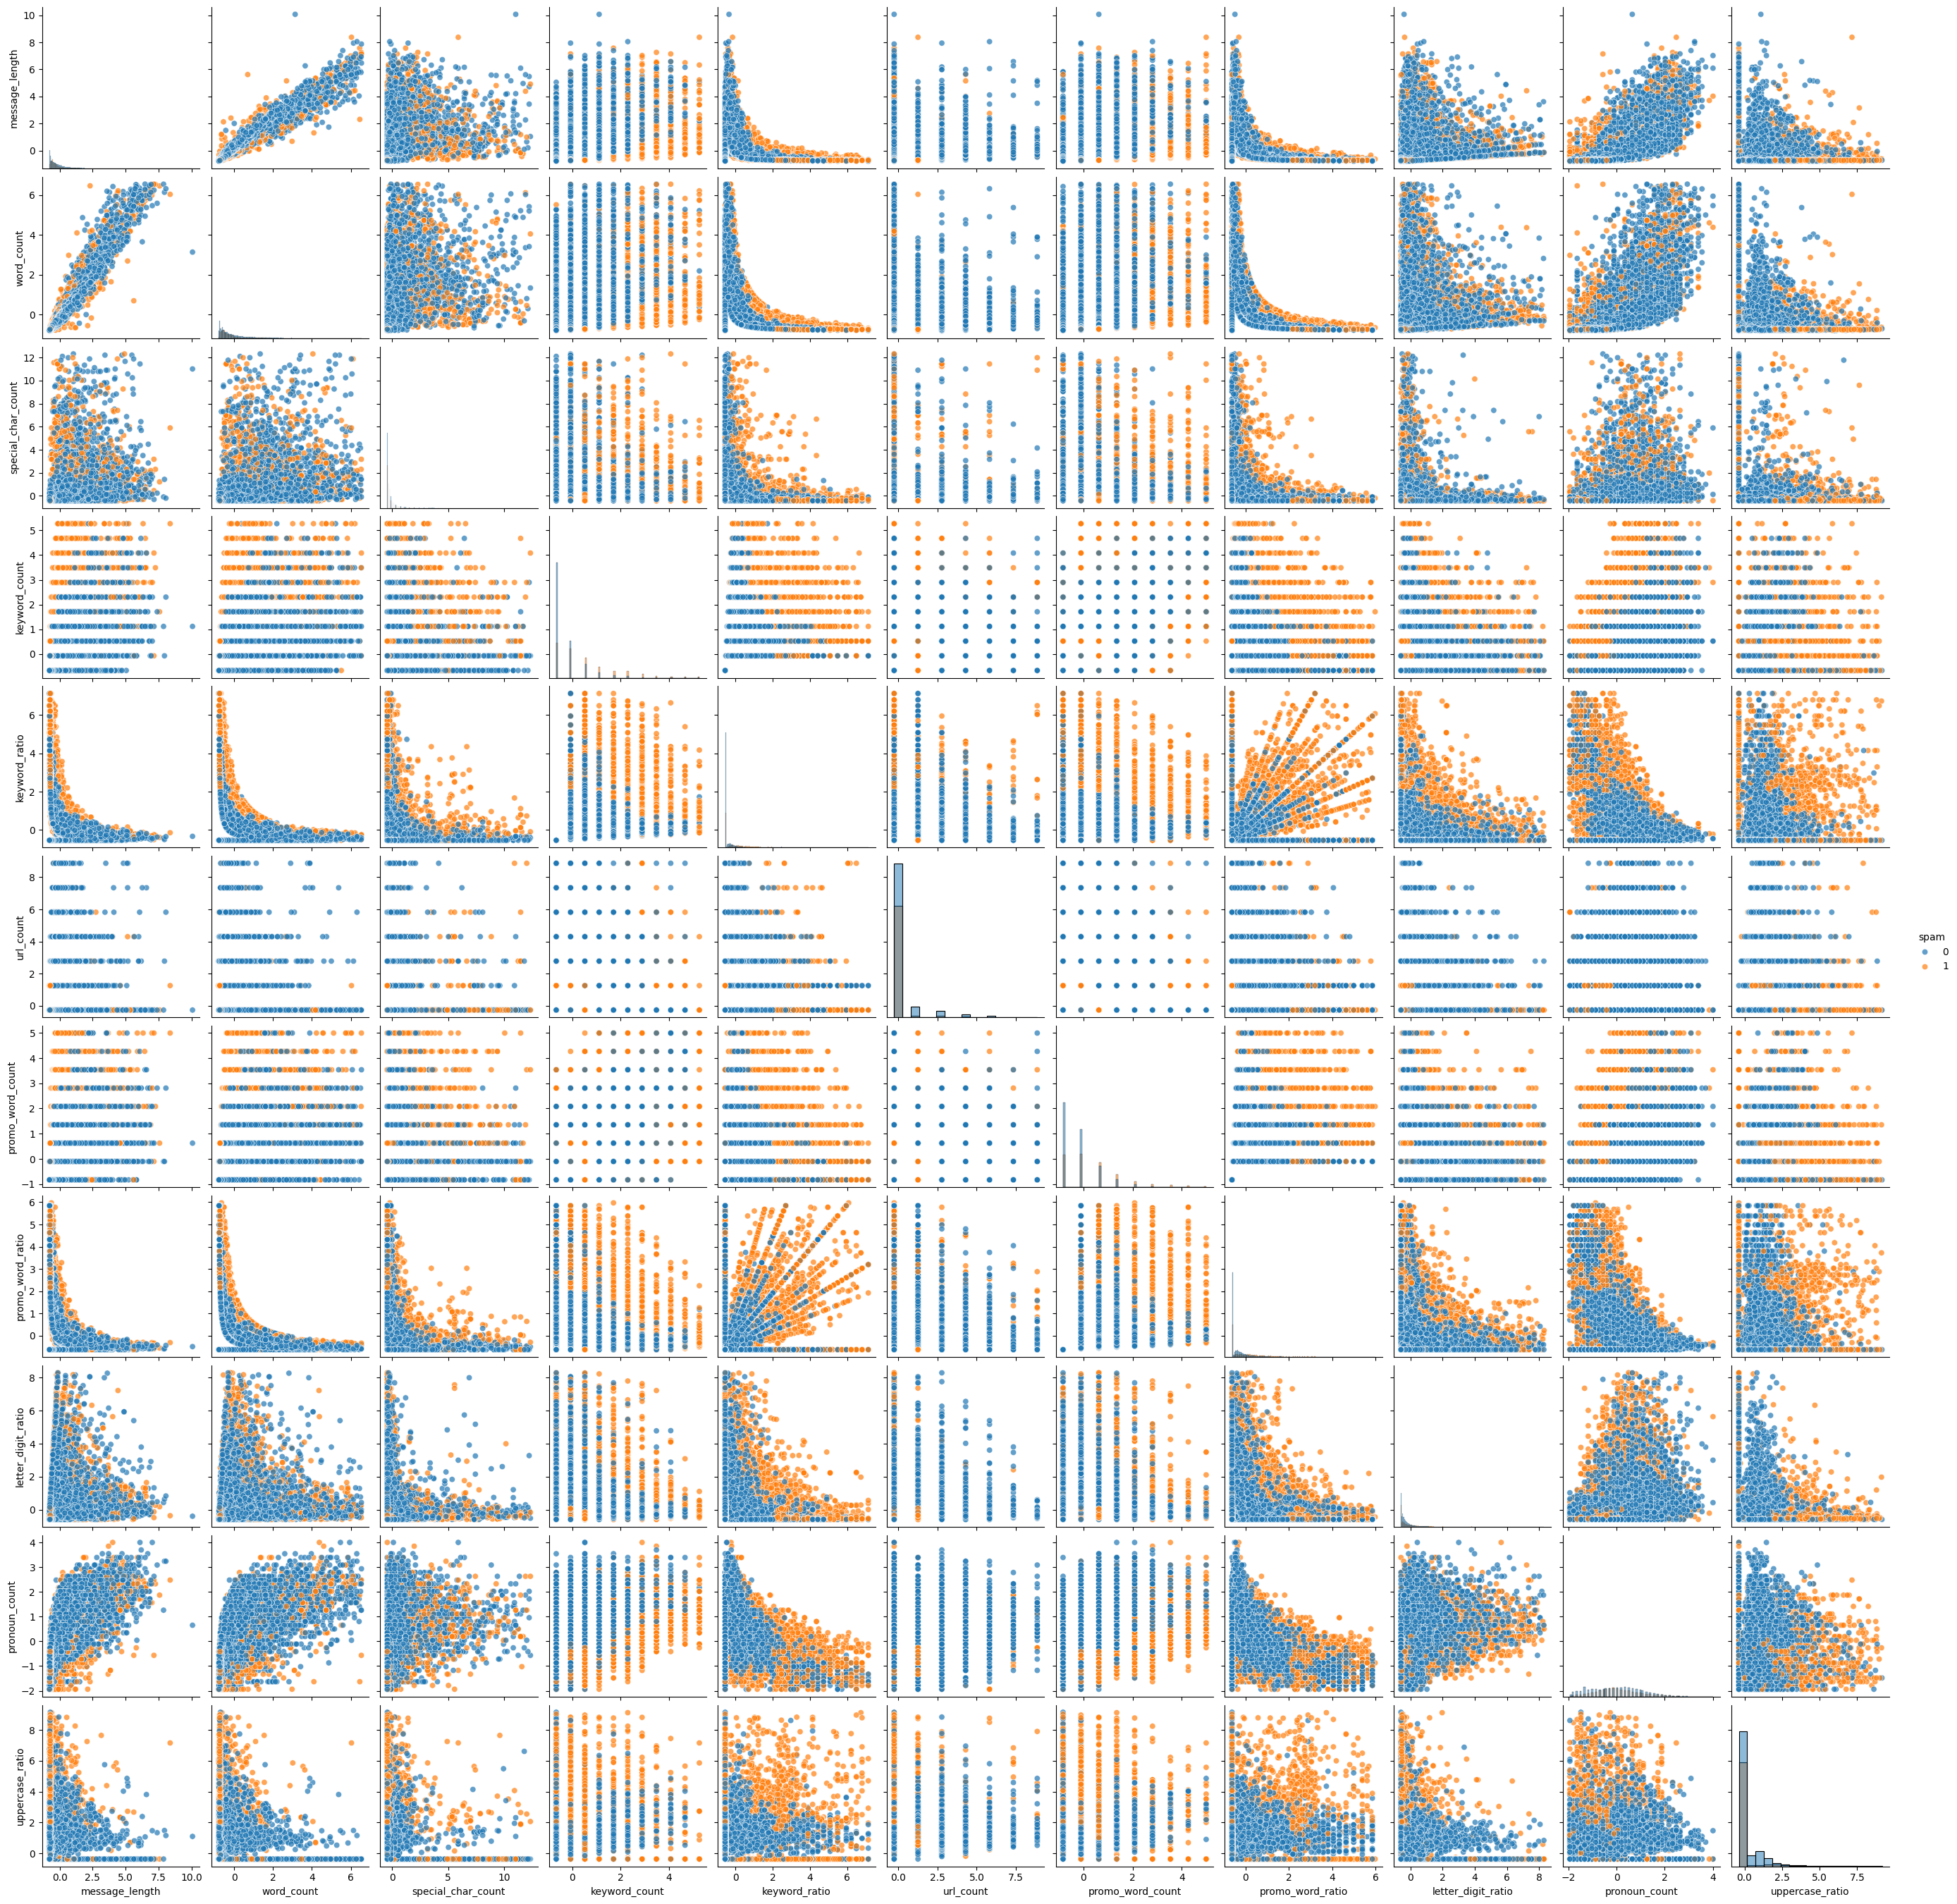

In [53]:
# Créer une copie du DataFrame pour ne pas modifier l'original et Standardiser les colonnes numériques
df_standardized = df.copy()


scaler = StandardScaler()
df_standardized[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Afficher un pairplot avec les données standardisées
sns.pairplot(df_standardized, hue="spam", kind="scatter", diag_kind="hist",plot_kws={'alpha': 0.7})

In [54]:
# Nous ne conserverons que les colonnes qui semblent avoir un lien de correlation et supprimons donc les autres (on oublie pas de garder message et spam)
numerical_features=['keyword_count', 'keyword_ratio', 'promo_word_count', 'promo_word_ratio', 'uppercase_ratio']
tokeep = numerical_features + ['spam', 'message']
# Filtrer les colonnes à garder dans 'numerical_cols'
columns_to_drop = [col for col in numerical_cols if col not in tokeep]
# Supprimer les colonnes qui ne sont pas dans 'tokeep'
df_cleaned = df.drop(columns=columns_to_drop)

del df_standardized,df_cleaned


#### &nbsp;&nbsp;b) Analyse PCA des données textuelles (message)

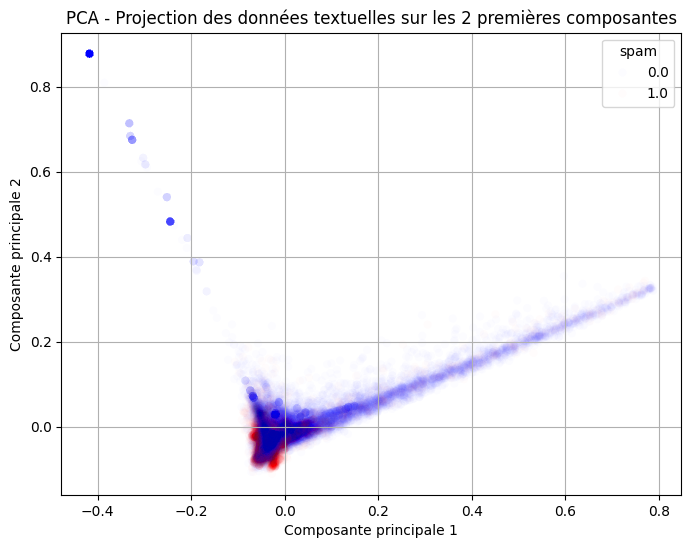

In [55]:
# Convertir la colonne 'text' en vecteurs numériques avec TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)  
X = vectorizer.fit_transform(df['message'])

# Appliquer le PCA pour réduire la dimensionnalité à 2
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)  # appliquons sur la matrice creuse sinon , débordement mémoire

# Créer un DataFrame avec les 2 premières composantes principales
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['spam'] = df['spam']  # Ajouter la colonne 'spam' pour la colorisation

plt.figure(figsize=(8, 6))

# Plot avec coloration en fonction de la colonne 'spam'
sns.scatterplot(x='PC1', y='PC2', data=df_pca, hue='spam', palette={0: 'blue', 1: 'red'}, alpha=0.01)


# Ajouter des labels et un titre
plt.title("PCA - Projection des données textuelles sur les 2 premières composantes")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.grid(True)
plt.show()

#### &nbsp;&nbsp;C) Analyse PCA des données numeriques

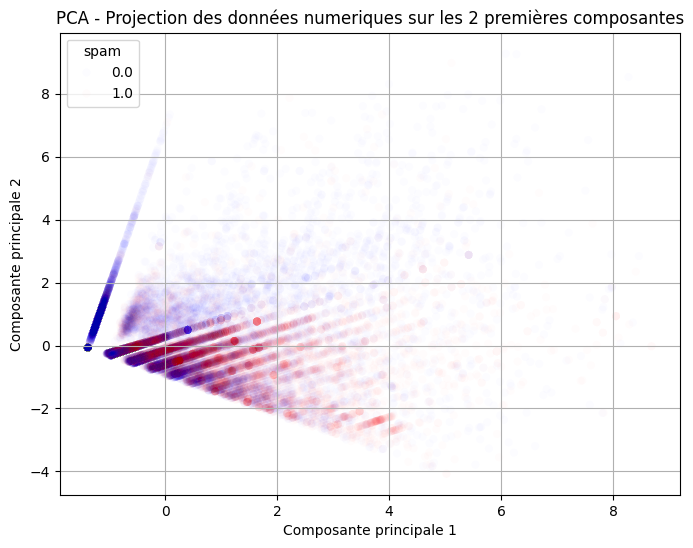

In [56]:
X = df[numerical_features]

# Normaliser les données avant d'appliquer le PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Appliquer le PCA pour réduire à 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Créer un DataFrame avec les composantes principales
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['spam']= df['spam']
# Visualiser les 2 premières composantes principales
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=df_pca, hue='spam', palette={0: 'blue', 1: 'red'}, alpha=0.01)
plt.title("PCA - Projection des données numeriques sur les 2 premières composantes")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.grid(True)
plt.show()

### 3-Selectionner un modèle

Tous les modèles présentés ont été fine-tuné avec un grid search cross validation et des valeurs autour des valeurs par defaut des modèles

#### &nbsp;&nbsp;A) Séparation du jeu de données en train et test

In [57]:
from sklearn.model_selection import train_test_split

In [58]:
X=df[numerical_features+['message']]
y=df['spam']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### &nbsp;&nbsp;B) Création du pipeline

In [59]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

In [60]:
models_to_test=['sgd','rf','xgboost']

In [61]:
def create_pipeline(modelname='sgd'):
    #chaque modele va préprocesser de la même manière
    preprocessor=ColumnTransformer(
            transformers=[
                ('text', TfidfVectorizer(max_features=5000), 'message'),  # Transformation des messages textuels
                ('num', StandardScaler(), numerical_features)  # Normalisation des colonnes numériques
            ])
    
    if(modelname=='sgd'):
        return Pipeline(steps=[
        ('preprocessor',preprocessor),
        ('sgd', SGDClassifier(alpha=0.0001,loss='hinge',max_iter=1000,penalty='l2'))  # Classificateur SGD
        ])
    elif(modelname=='rf'):
        return Pipeline(steps=[
        ('preprocessor',preprocessor),
        ('rf', RandomForestClassifier(n_estimators=500,random_state=42,max_depth=30,min_samples_leaf=1,min_samples_split=5))  # Random Forrest
        ])
    else:
        return Pipeline(steps=[
        ('preprocessor',preprocessor),
        ('xgb', XGBClassifier( eval_metric='logloss', random_state=42,objective="binary:logistic",learning_rate=0.2,max_depth=7,n_estimators=300,subsample=1))
        ])


#### &nbsp;&nbsp;C) Entrainer les modèles et prédire

In [62]:
import joblib


In [63]:
predictions_results={}

for model_to_test in models_to_test:
    pipe=create_pipeline(model_to_test)
    pipe.fit(X_train,y_train)
    predictions_results[model_to_test]=pipe.predict(X_test)
    joblib.dump(pipe, model_to_test+'.joblib')

#### &nbsp;&nbsp;D) Comparer les résultats

In [64]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score

Modèle testé :  sgd


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      4795
           1       0.96      0.95      0.96      3017

    accuracy                           0.97      7812
   macro avg       0.96      0.96      0.96      7812
weighted avg       0.97      0.97      0.97      7812


Confusion Matrix:


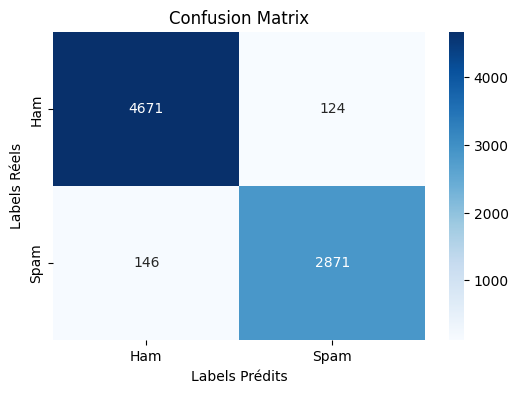

Modèle testé :  rf


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      4795
           1       0.97      0.87      0.92      3017

    accuracy                           0.94      7812
   macro avg       0.95      0.93      0.94      7812
weighted avg       0.94      0.94      0.94      7812


Confusion Matrix:


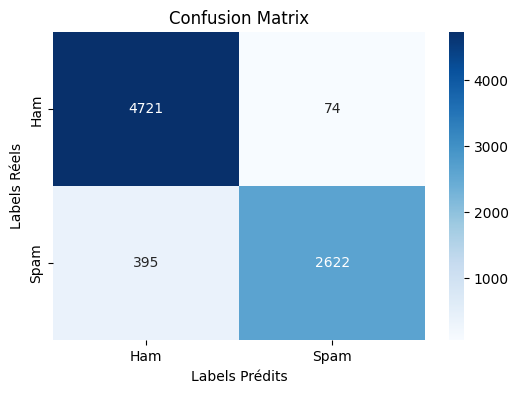

Modèle testé :  xgboost


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4795
           1       0.96      0.97      0.97      3017

    accuracy                           0.98      7812
   macro avg       0.97      0.97      0.97      7812
weighted avg       0.98      0.98      0.98      7812


Confusion Matrix:


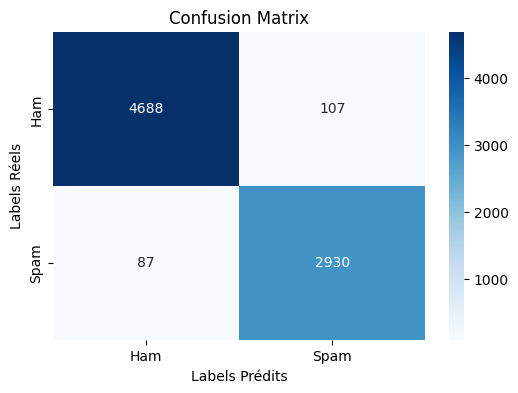

In [65]:
f1scores={}
for model_to_test in models_to_test:
    y_pred=predictions_results[model_to_test]
    print("Modèle testé : ",model_to_test)
    
    #classification report
    print("\n\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    f1scores[model_to_test]=f1_score(y_test, y_pred)
    #matrice de confusion
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    class_labels = ['Ham', 'Spam']

    # Créer une figure pour la heatmap
    plt.figure(figsize=(6, 4))

    # Afficher la matrice de confusion en tant que heatmap
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Labels Prédits')
    plt.ylabel('Labels Réels')
    # Afficher la figure
    plt.show()
    
    

#### &nbsp;&nbsp;E) Sauvegarder le meilleur modèle

In [66]:
import os
import shutil

In [67]:
best_model = max(f1scores, key=f1scores.get)
best_f1score = f1scores[best_model]
print(f"\nLe modèle avec le F1-score le plus élevé est '{best_model}' avec un F1-score de {best_f1score} il a été sauvegardé dans spam.joblib")

#renommage du gagnant et suppression des perdants
shutil.move(model_to_test+'.joblib', 'spam.joblib')
for model_to_test in models_to_test:
    if os.path.exists(model_to_test+'.joblib'):
        os.remove(model_to_test+'.joblib')


Le modèle avec le F1-score le plus élevé est 'xgboost' avec un F1-score de 0.9679550710274198 il a été sauvegardé dans spam.joblib
